<a href="https://colab.research.google.com/github/supakornpao/classification_models/blob/main/Copy_of_fashionproduct_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as npt
import pandas as pd
import pickle

import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import plotly.express as px

import math
from joblib import Parallel, delayed
import PIL
from PIL import Image
import os
import warnings
warnings.filterwarnings('ignore')

In [2]:
!pip install kaggle

In [3]:
!mkdir ~/.kaggle

In [4]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

# Then move kaggle.json into the folder where the API expects to find it.

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 72 bytes


In [5]:
!mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

In [6]:
!kaggle competitions list

ref                                                                                 deadline             category                reward  teamCount  userHasEntered  
----------------------------------------------------------------------------------  -------------------  ---------------  -------------  ---------  --------------  
https://www.kaggle.com/competitions/ai-mathematical-olympiad-progress-prize-3       2026-04-15 23:59:00  Featured         2,207,152 Usd        528           False  
https://www.kaggle.com/competitions/hull-tactical-market-prediction                 2025-12-15 23:59:00  Featured           100,000 Usd       3116           False  
https://www.kaggle.com/competitions/vesuvius-challenge-surface-detection            2026-02-13 23:59:00  Research           100,000 Usd        256           False  
https://www.kaggle.com/competitions/google-tunix-hackathon                          2026-01-12 23:59:00  Featured           100,000 Usd         72           False  
https://ww

In [7]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("paramaggarwal/fashion-product-images-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'fashion-product-images-dataset' dataset.
Path to dataset files: /kaggle/input/fashion-product-images-dataset


In [8]:
styles = pd.read_csv("/kaggle/input/fashion-product-images-dataset/fashion-dataset/styles.csv", on_bad_lines='skip')
styles.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [9]:
styles.shape

(44424, 10)

In [10]:
#remove unimportant features
styles.drop(
    ['gender', 'articleType', 'baseColour', 'season', 'year', 'usage', 'productDisplayName'],
    axis = 1,
    inplace = True
)
styles.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44424 entries, 0 to 44423
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              44424 non-null  int64 
 1   masterCategory  44424 non-null  object
 2   subCategory     44424 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.0+ MB


In [11]:
styles['masterCategory'].unique()

array(['Apparel', 'Accessories', 'Footwear', 'Personal Care',
       'Free Items', 'Sporting Goods', 'Home'], dtype=object)

In [12]:
styles['masterCategory'].nunique()

7

In [13]:
styles['subCategory'].unique()

array(['Topwear', 'Bottomwear', 'Watches', 'Socks', 'Shoes', 'Belts',
       'Flip Flops', 'Bags', 'Innerwear', 'Sandal', 'Shoe Accessories',
       'Fragrance', 'Jewellery', 'Lips', 'Saree', 'Eyewear', 'Nails',
       'Scarves', 'Dress', 'Loungewear and Nightwear', 'Wallets',
       'Apparel Set', 'Headwear', 'Mufflers', 'Skin Care', 'Makeup',
       'Free Gifts', 'Ties', 'Accessories', 'Skin', 'Beauty Accessories',
       'Water Bottle', 'Eyes', 'Bath and Body', 'Gloves',
       'Sports Accessories', 'Cufflinks', 'Sports Equipment', 'Stoles',
       'Hair', 'Perfumes', 'Home Furnishing', 'Umbrellas', 'Wristbands',
       'Vouchers'], dtype=object)

In [14]:
styles['subCategory'].nunique()

45

In [15]:
NUM_CORES = os.cpu_count()
BATCH_SIZE = 32
SCALING_SIZE = (64,64)

In [16]:
bar_values = []
for category in styles['subCategory'].unique():
    bar_values.append(round(styles[styles['subCategory'] == category].shape[0] * 100 / styles.shape[0], 2))
bar_values.sort(reverse=True)
fig = px.bar(
    x = styles['subCategory'].unique(),
    y = bar_values,
    title = "Data Percentage",
    labels={'x': 'SubCategories', 'y':'Percentage'}
)
fig.update_traces(marker_color='rgb(0,128,0)')
fig.update_layout(title_x = 0.5)
fig.show()

In [17]:
class_distribution = styles['masterCategory'].value_counts(normalize=True) * 100
result = pd.DataFrame({
    'Samples': styles['masterCategory'].value_counts(),
    'Percentage': class_distribution.round(2)
})
print(result)

                Samples  Percentage
masterCategory                     
Apparel           21397       48.17
Accessories       11274       25.38
Footwear           9219       20.75
Personal Care      2403        5.41
Free Items          105        0.24
Sporting Goods       25        0.06
Home                  1        0.00


In [18]:

class_distribution = styles['subCategory'].value_counts(normalize=True) * 100
result = pd.DataFrame({
    'Samples': styles['subCategory'].value_counts(),
    'Percentage': class_distribution.round(2)
})
print(result)

                          Samples  Percentage
subCategory                                  
Topwear                     15402       34.67
Shoes                        7343       16.53
Bags                         3055        6.88
Bottomwear                   2694        6.06
Watches                      2542        5.72
Innerwear                    1808        4.07
Jewellery                    1079        2.43
Eyewear                      1073        2.42
Fragrance                    1011        2.28
Sandal                        963        2.17
Wallets                       933        2.10
Flip Flops                    913        2.06
Belts                         811        1.83
Socks                         698        1.57
Lips                          527        1.19
Dress                         478        1.08
Loungewear and Nightwear      470        1.06
Saree                         427        0.96
Nails                         329        0.74
Makeup                        307 

In [19]:
styles[styles['subCategory'].isin(['Topwear', 'Shoes', 'Bags','Bottomwear','Watches'])]

,id,masterCategory,subCategory
0,15970,Apparel,Topwear
1,39386,Apparel,Bottomwear
2,59263,Accessories,Watches
3,21379,Apparel,Bottomwear
4,53759,Apparel,Topwear
...,...,...,...
44417,12544,Apparel,Topwear
44418,42234,Apparel,Topwear
44419,17036,Footwear,Shoes
44421,18842,Apparel,Topwear


In [20]:
styles = styles[styles['subCategory'].isin(['Topwear', 'Shoes', 'Bags','Bottomwear','Watches'])]
styles = styles.groupby('subCategory').sample(n=1000,random_state=101)
print(styles['subCategory'].value_counts())

subCategory
Bags          1000
Bottomwear    1000
Shoes         1000
Topwear       1000
Watches       1000
Name: count, dtype: int64


In [21]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
styles['subCategory'] = encoder.fit_transform(styles['subCategory'])
decoder_dict = {}
for index, _class in enumerate(encoder.classes_):
    decoder_dict[index] = _class

decoder_dict

{0: 'Bags', 1: 'Bottomwear', 2: 'Shoes', 3: 'Topwear', 4: 'Watches'}

In [22]:
styles.head()

,id,masterCategory,subCategory
9543,34770,Accessories,0
31870,42937,Accessories,0
15255,20567,Accessories,0
624,47361,Accessories,0
12872,44280,Accessories,0


In [23]:
list(decoder_dict.keys())

[0, 1, 2, 3, 4]

In [24]:
import pickle
print("\nSave label encoder")
with open('label_encoder.pkl', 'wb') as f:
    pickle.dump(encoder, f)


Save label encoder


In [25]:
styles['id']

,id
9543,34770
31870,42937
15255,20567
624,47361
12872,44280
...,...
41902,19765
41792,47978
38727,21683
17911,16775


In [26]:
from sklearn.model_selection import train_test_split
#Train & Tests set
X_train, X_test, y_train, y_test = train_test_split(
    styles['id'],
    styles['subCategory'],
    test_size=0.2,
    random_state=101,
    stratify=styles['subCategory']
)

#Validation Set from Train
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.2,
    random_state=101,
    stratify=y_train
)


In [27]:
X_train

,id
21842,45873
15763,12254
17337,16744
7324,10581
38655,33983
...,...
17333,17696
22800,45239
27941,40034
2860,1608


In [28]:
X_train = X_train.reset_index()
X_train.drop("index", axis = 1, inplace = True)

X_test = X_test.reset_index()
X_test.drop("index", axis = 1, inplace = True)

X_val = X_val.reset_index()
X_val.drop("index", axis = 1, inplace = True)

y_train = y_train.reset_index()
y_train.drop("index", axis = 1, inplace = True)

y_test = y_test.reset_index()
y_test.drop("index", axis = 1, inplace = True)

y_val = y_val.reset_index()
y_val.drop("index", axis = 1, inplace = True)

X_train.head()

,id
0,45873
1,12254
2,16744
3,10581
4,33983


In [29]:
#Change id to string
X_train['id'] = X_train['id'].apply(str)
X_test['id'] = X_test['id'].apply(str)
X_val['id'] = X_val['id'].apply(str)

X_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3200 entries, 0 to 3199
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      3200 non-null   object
dtypes: object(1)
memory usage: 25.1+ KB


In [30]:
class Preprocessing():
    # constructor
    def __init__(self, df, y):
        self.df = df
        self.y = y

    # get final dataframe
    def get_final_image(self):
        return (self.df, self.y)


    def remove_non_existing_images(self):
        for _id in self.df['id']:
            path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
            if(not os.path.exists(path)):
                index = self.df[self.df['id'] == _id].index
                self.df.drop(index, inplace = True)
                self.y.drop(index, inplace = True)


    def generate_batches(self, batch_size):
        number_of_batches = math.ceil(self.df.shape[0] / batch_size)
        batch_indices = []
        self.batch_size = batch_size
        prev_index = -1
        for index in range(number_of_batches):
            if(index != number_of_batches - 1):
                batch_indices.append((prev_index + 1, prev_index + batch_size))
            else:
                batch_indices.append((prev_index + 1, self.df.shape[0]))
            prev_index += batch_size
        self.batch_indices = batch_indices
        return batch_indices

In [31]:
%%time
# training set proprocessing
training_preprocessor = Preprocessing(X_train, y_train)
training_preprocessor.remove_non_existing_images()
training_batches = training_preprocessor.generate_batches(BATCH_SIZE)
X_train, y_train = training_preprocessor.get_final_image()

# validation set preprocessing
val_preprocessor = Preprocessing(X_val, y_val)
val_preprocessor.remove_non_existing_images()
val_batches = val_preprocessor.generate_batches(BATCH_SIZE)
X_val, y_val = val_preprocessor.get_final_image()

# test set preprocessing
test_preprocessor = Preprocessing(X_test, y_test)
test_preprocessor.remove_non_existing_images()
test_batches = test_preprocessor.generate_batches(BATCH_SIZE)
X_test, y_test = test_preprocessor.get_final_image()

CPU times: user 64.4 ms, sys: 146 ms, total: 211 ms
Wall time: 13.7 s


In [36]:
import numpy as np
def load_all_images(index, _id):
    path = "/kaggle/input/fashion-product-images-dataset/fashion-dataset/images/" + _id + ".jpg"
    _image = Image.open(path)
    _image = _image.convert('L') # grayscale
    _image = _image.resize(SCALING_SIZE) # resize
    _image = np.asarray(_image)
    return _image

In [37]:
# parallely load all images for individual datasets
delayed_funcs = [delayed(load_all_images)(index, _id) for index, _id in enumerate(X_train['id'])]
parallel_pool = Parallel(n_jobs=NUM_CORES, backend = 'multiprocessing', verbose = 10)
train_image = parallel_pool(delayed_funcs)

delayed_funcs = [delayed(load_all_images)(index, _id) for index, _id in enumerate(X_val['id'])]
parallel_pool = Parallel(n_jobs=NUM_CORES, backend = 'multiprocessing', verbose = 10)
val_image = parallel_pool(delayed_funcs)

delayed_funcs = [delayed(load_all_images)(index, _id) for index, _id in enumerate(X_test['id'])]
parallel_pool = Parallel(n_jobs=NUM_CORES, backend = 'multiprocessing', verbose = 10)
test_image = parallel_pool(delayed_funcs)

[Parallel(n_jobs=2)]: Using backend MultiprocessingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done    1 out of 3200 | elapsed:    0.4s
[Parallel(n_jobs=2)]: Batch computation too fast (0.09297609329223633s.) Setting batch_size=2.
[Parallel(n_jobs=2)]: Done    4 out of 3200 | elapsed:    0.5s
[Parallel(n_jobs=2)]: Done   14 out of 3200 | elapsed:    1.3s
[Parallel(n_jobs=2)]: Done   24 out of 3200 | elapsed:    2.0s
[Parallel(n_jobs=2)]: Done   38 out of 3200 | elapsed:    3.1s
[Parallel(n_jobs=2)]: Done   52 out of 3200 | elapsed:    4.4s
[Parallel(n_jobs=2)]: Done   70 out of 3200 | elapsed:    5.2s
[Parallel(n_jobs=2)]: Done   88 out of 3200 | elapsed:    6.0s
[Parallel(n_jobs=2)]: Done  110 out of 3200 | elapsed:    7.0s
[Parallel(n_jobs=2)]: Done  132 out of 3200 | elapsed:    7.5s
[Parallel(n_jobs=2)]: Done  158 out of 3200 | elapsed:    8.2s
[Parallel(n_jobs=2)]: Batch computation too fast (0.19736382386296866s.) Setting batch_size=4.
[Parallel(n_jobs=2)]: Done  200

In [38]:
X_train

,id
0,45873
1,12254
2,16744
3,10581
4,33983
...,...
3195,17696
3196,45239
3197,40034
3198,1608


In [39]:
X_test

,id
0,31430
1,46975
2,30617
3,26310
4,9397
...,...
995,6496
996,17623
997,30107
998,57216


In [40]:
X_train_img = np.array(train_image).reshape(-1, SCALING_SIZE[0], SCALING_SIZE[1], 1) / 255.0
X_val_img   = np.array(val_image).reshape(-1, SCALING_SIZE[0], SCALING_SIZE[1], 1) / 255.0
X_test_img  = np.array(test_image).reshape(-1, SCALING_SIZE[0], SCALING_SIZE[1], 1) / 255.0

y_train_flat = np.asarray(y_train).ravel()
y_val_flat   = np.asarray(y_val).ravel()
y_test_flat  = np.asarray(y_test).ravel()

X_train_img = X_train_img.astype('float32')
X_val_img   = X_val_img.astype('float32')
X_test_img  = X_test_img.astype('float32')

In [41]:
X_train_img.shape
#22342 samples, 64x64 pixels

(3200, 64, 64, 1)

In [42]:
X_test_img.shape
#3104 samples, 64x64 pixels

(1000, 64, 64, 1)

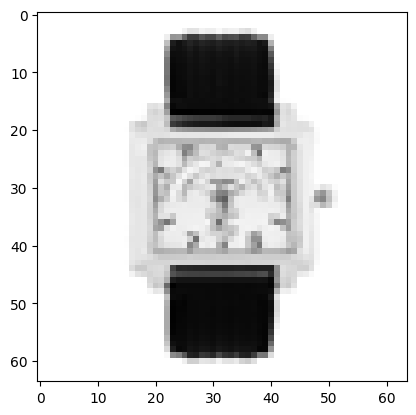

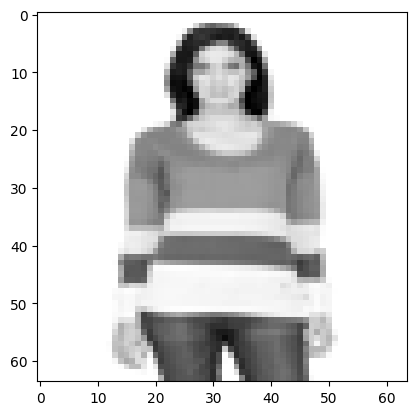

In [43]:
from matplotlib import pyplot as plt
plt.imshow(X_train_img[0],cmap=plt.cm.gray) #train image
plt.show()
plt.imshow(X_test_img[7],cmap=plt.cm.gray) #test image
plt.show()

In [44]:
import keras
from keras.models import Sequential
from keras import layers

model = Sequential([
    layers.Conv2D(64, (5, 5), activation='relu', input_shape=(SCALING_SIZE[0], SCALING_SIZE[1], 1)),
    layers.MaxPool2D((2, 2)),

    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPool2D((2, 2)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(len(decoder_dict), activation='softmax')
])

model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 60, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 26, 26, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 13, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │        54,085 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 158,213 (618.02 KB)

 Trainable params: 158,213 (618.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# import keras
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

In [45]:
%%time

history = model.fit(
    X_train_img,
    y_train_flat,
    epochs=15,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_img, y_val_flat),
    verbose=1,
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.6422 - loss: 0.9296 - val_accuracy: 0.9513 - val_loss: 0.1900
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9567 - loss: 0.1555 - val_accuracy: 0.9650 - val_loss: 0.1519
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9718 - loss: 0.1016 - val_accuracy: 0.9513 - val_loss: 0.1609
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9729 - loss: 0.0896 - val_accuracy: 0.9675 - val_loss: 0.1533
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9820 - loss: 0.0643 - val_accuracy: 0.9650 - val_loss: 0.1482
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9845 - loss: 0.0538 - val_accuracy: 0.9663 - val_loss: 0.1515
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9886 - loss: 0.0331 - val_accuracy: 0.9675 - val_loss: 0.1756
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.9858 - loss: 0.0436 - val_accuracy: 0

In [46]:
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score
y_pred_proba = model.predict(X_test_img)
y_pred = np.argmax(y_pred_proba, axis=1)


print(classification_report(
    y_test_flat,
    y_pred,
    target_names=encoder.classes_
))

test_loss, test_acc = model.evaluate(X_test_img, y_test_flat, verbose=0)
print(f"\nTest Accuracy (Keras): {test_acc:.4f}")
print(f"\nTest Loss (Keras): {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

        Bags       0.97      0.97      0.97       200
  Bottomwear       0.99      0.97      0.98       200
       Shoes       1.00      0.98      0.99       200
     Topwear       0.97      0.98      0.97       200
     Watches       0.96      0.99      0.98       200

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Test Accuracy (Keras): 0.9790

Test Loss (Keras): 0.0930


In [257]:
y_pred_proba_val1 = model.predict(X_val_img)
y_pred_val1 = np.argmax(y_pred_proba_val1, axis=1)
print(classification_report(
    y_val_flat,
    y_pred_val1,
    target_names=encoder.classes_
))
val_loss, val_acc = model.evaluate(X_val_img, y_val_flat, verbose=0)
print(f"\nVal 1 Accuracy (Keras): {val_acc:.4f}")
print(f"\nVal 1 Loss (Keras): {val_loss:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

        Bags       0.98      0.97      0.98       160
  Bottomwear       0.99      0.94      0.96       160
       Shoes       0.99      0.99      0.99       160
     Topwear       0.93      0.97      0.95       160
     Watches       0.96      0.97      0.97       160

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800


Val 1 Accuracy (Keras): 0.9712

Val 1 Loss (Keras): 0.2439


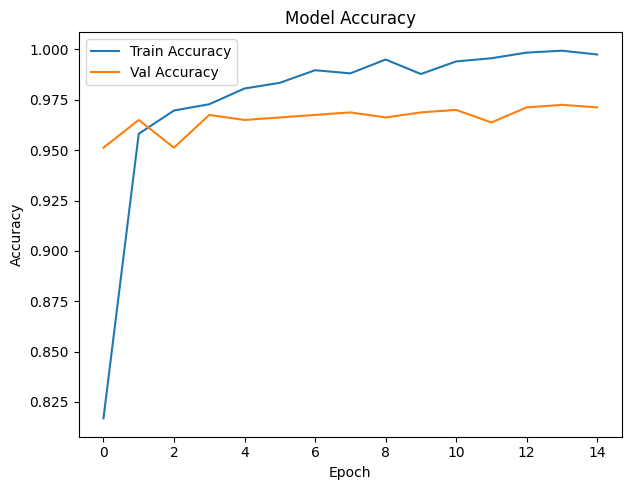

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

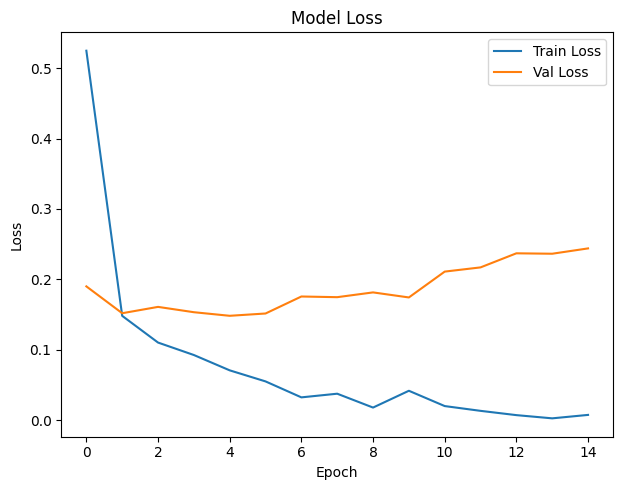

In [48]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [49]:
list(encoder.classes_)

['Bags', 'Bottomwear', 'Shoes', 'Topwear', 'Watches']

In [50]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay
cm = confusion_matrix(y_test_flat,y_pred,labels=list(decoder_dict.keys()))

In [51]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=list(decoder_dict.keys()))

0-> Bags
1-> Bottomwear
2-> Shoes
3-> Topwear
4-> Watches


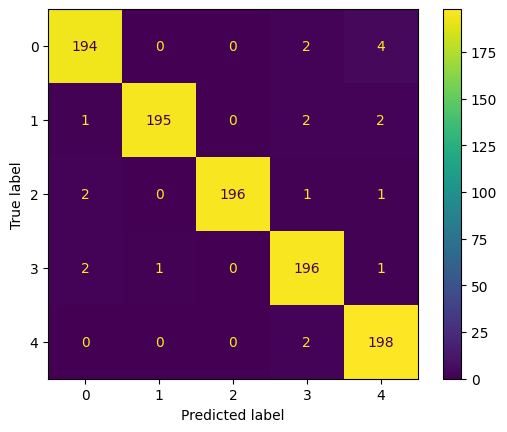

In [52]:
disp.plot()
for i in list(decoder_dict.keys()):
  print(str(i)+"-> "+decoder_dict[i])

Validation model 1
0-> Bags
1-> Bottomwear
2-> Shoes
3-> Topwear
4-> Watches


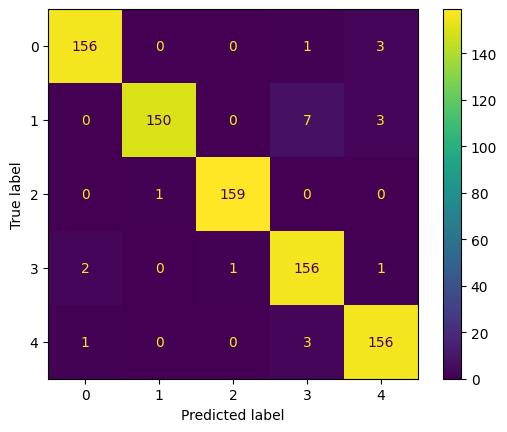

In [253]:
cm_val1 = confusion_matrix(y_val_flat,y_pred_val1,labels=list(decoder_dict.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val1,display_labels=list(decoder_dict.keys()))
disp.plot()
print("Validation model 1")
for i in list(decoder_dict.keys()):
  print(str(i)+"-> "+decoder_dict[i])

#Another Model

#Max Pooling (4,4)

In [53]:
model2 = Sequential([
    layers.Conv2D(64, (5, 5), activation='relu', input_shape=(SCALING_SIZE[0], SCALING_SIZE[1], 1)),
    layers.MaxPool2D((4, 4)),

    layers.Conv2D(64, (5, 5), activation='relu'),
    layers.MaxPool2D((4, 4)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(len(decoder_dict), activation='softmax')
])

model2.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 11, 11, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 2, 2, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 105,413 (411.77 KB)

 Trainable params: 105,413 (411.77 KB)

 Non-trainable params: 0 (0.00 B)

In [54]:
history2 = model2.fit(
    X_train_img,
    y_train_flat,
    epochs=15,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_img, y_val_flat),
    verbose=1,
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.4662 - loss: 1.3616 - val_accuracy: 0.8950 - val_loss: 0.4252
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8658 - loss: 0.4295 - val_accuracy: 0.9287 - val_loss: 0.2939
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9144 - loss: 0.2709 - val_accuracy: 0.9325 - val_loss: 0.2443
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9254 - loss: 0.2316 - val_accuracy: 0.9438 - val_loss: 0.2252
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9369 - loss: 0.2088 - val_accuracy: 0.9525 - val_loss: 0.1902
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9436 - loss: 0.1882 - val_accuracy: 0.9563 - val_loss: 0.1879
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9599 - loss: 0.1449 - val_accuracy: 0.9538 - val_loss: 0.1876
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9492 - loss: 0.1511 - val_accuracy: 0

In [55]:
y_pred_proba2 = model2.predict(X_test_img)
y_pred2 = np.argmax(y_pred_proba2, axis=1)


print(classification_report(
    y_test_flat,
    y_pred2,
    target_names=encoder.classes_
))

test_loss, test_acc = model2.evaluate(X_test_img, y_test_flat, verbose=0)
print(f"\nTest Accuracy (Keras): {test_acc:.4f}")
print(f"\nTest Loss (Keras): {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step
              precision    recall  f1-score   support

        Bags       0.98      0.97      0.98       200
  Bottomwear       0.98      0.95      0.97       200
       Shoes       0.99      1.00      1.00       200
     Topwear       0.97      0.97      0.97       200
     Watches       0.96      0.98      0.97       200

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Test Accuracy (Keras): 0.9760

Test Loss (Keras): 0.0779


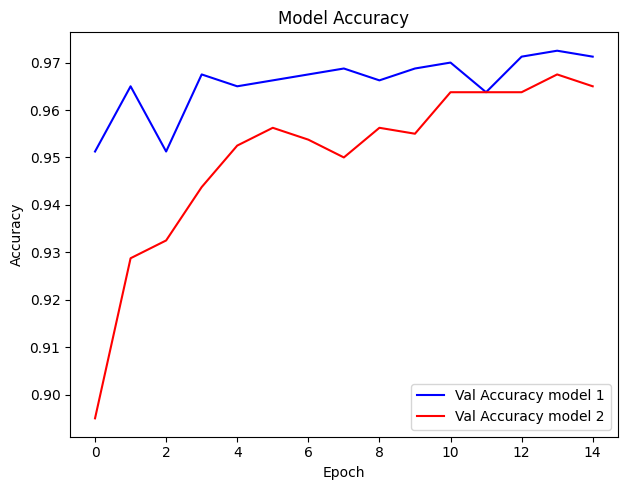

In [56]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Val Accuracy model 1', color='blue')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy model 2', color='red')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()


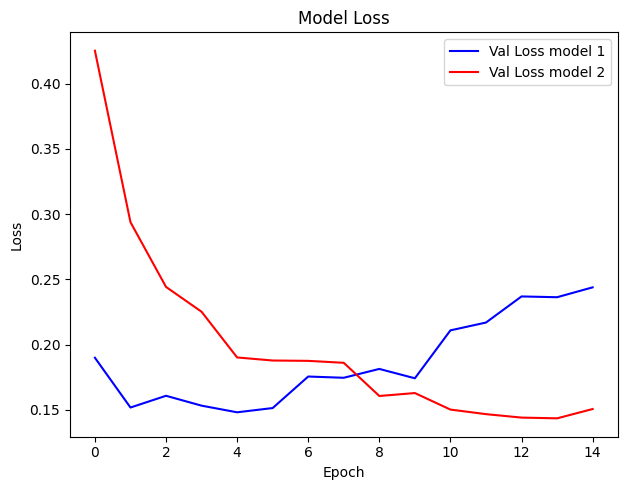

In [57]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
#plt.plot(history2.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss model 1',color='blue')
plt.plot(history2.history['val_loss'], label='Val Loss model 2',color='red')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()



In [256]:
y_pred_proba_val2 = model2.predict(X_val_img)
y_pred_val2 = np.argmax(y_pred_proba_val2, axis=1)
print(classification_report(
    y_val_flat,
    y_pred_val2,
    target_names=encoder.classes_
))
val_loss2, val_acc2 = model2.evaluate(X_val_img, y_val_flat, verbose=0)
print(f"\nVal 2 Accuracy (Keras): {val_acc2:.4f}")
print(f"\nVal 2 Loss (Keras): {val_loss2:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
              precision    recall  f1-score   support

        Bags       0.96      0.97      0.97       160
  Bottomwear       0.98      0.93      0.95       160
       Shoes       0.98      0.99      0.98       160
     Topwear       0.94      0.96      0.95       160
     Watches       0.96      0.97      0.97       160

    accuracy                           0.96       800
   macro avg       0.97      0.97      0.96       800
weighted avg       0.97      0.96      0.96       800


Val 2 Accuracy (Keras): 0.9650

Val 2 Loss (Keras): 0.1507


Validation model 2
0-> Bags
1-> Bottomwear
2-> Shoes
3-> Topwear
4-> Watches


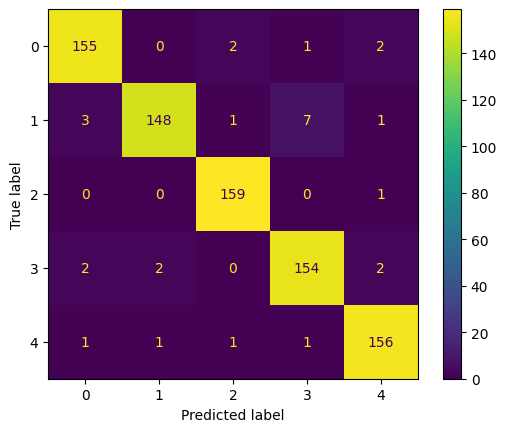

In [248]:
cm_val2 = confusion_matrix(y_val_flat,y_pred_val2,labels=list(decoder_dict.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val2,display_labels=list(decoder_dict.keys()))
disp.plot()
print("Validation model 2")
for i in list(decoder_dict.keys()):
  print(str(i)+"-> "+decoder_dict[i])

#Kernel size 3x3 + Max Pooling (4,4)

In [58]:
model3 = Sequential([
    layers.Conv2D(64, (3, 3), activation='relu', input_shape=(SCALING_SIZE[0], SCALING_SIZE[1], 1)),
    layers.MaxPool2D((4, 4)),

    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPool2D((4, 4)),
    layers.Dropout(0.2),

    layers.Flatten(),
    layers.Dense(len(decoder_dict), activation='softmax')
])

model3.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model3.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 62, 62, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 13, 13, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 3, 3, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         2,885 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 40,453 (158.02 KB)

 Trainable params: 40,453 (158.02 KB)

 Non-trainable params: 0 (0.00 B)

In [59]:
history3 = model3.fit(
    X_train_img,
    y_train_flat,
    epochs=15,
    batch_size=BATCH_SIZE,
    validation_data=(X_val_img, y_val_flat),
    verbose=1
)

Epoch 1/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.4745 - loss: 1.3821 - val_accuracy: 0.8700 - val_loss: 0.4555
Epoch 2/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8782 - loss: 0.3925 - val_accuracy: 0.9050 - val_loss: 0.3247
Epoch 3/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9203 - loss: 0.2563 - val_accuracy: 0.9350 - val_loss: 0.2424
Epoch 4/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9395 - loss: 0.2169 - val_accuracy: 0.9388 - val_loss: 0.2058
Epoch 5/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9349 - loss: 0.2002 - val_accuracy: 0.9463 - val_loss: 0.1872
Epoch 6/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9530 - loss: 0.1659 - val_accuracy: 0.9513 - val_loss: 0.1691
Epoch 7/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9603 - loss: 0.1250 - val_accuracy: 0.9575 - val_loss: 0.1598
Epoch 8/15
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9664 - loss: 0.1320 - val_accuracy: 0

In [60]:
y_pred_proba3 = model3.predict(X_test_img)
y_pred3 = np.argmax(y_pred_proba3, axis=1)


print(classification_report(
    y_test_flat,
    y_pred3,
    target_names=encoder.classes_
))

test_loss, test_acc = model3.evaluate(X_test_img, y_test_flat, verbose=0)
print(f"\nTest Accuracy (Keras): {test_acc:.4f}")
print(f"\nTest Loss (Keras): {test_loss:.4f}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step
              precision    recall  f1-score   support

        Bags       0.98      0.98      0.98       200
  Bottomwear       0.99      0.94      0.97       200
       Shoes       0.99      0.99      0.99       200
     Topwear       0.97      0.98      0.98       200
     Watches       0.96      0.98      0.97       200

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000


Test Accuracy (Keras): 0.9770

Test Loss (Keras): 0.0680


In [255]:
y_pred_proba_val3 = model3.predict(X_val_img)
y_pred_val3 = np.argmax(y_pred_proba_val3, axis=1)
print(classification_report(
    y_val_flat,
    y_pred_val3,
    target_names=encoder.classes_
))
val_loss3, val_acc3 = model3.evaluate(X_val_img, y_val_flat, verbose=0)
print(f"\nVal 3 Accuracy (Keras): {val_acc3:.4f}")
print(f"\nVal 3 Loss (Keras): {val_loss3:.4f}")

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
              precision    recall  f1-score   support

        Bags       0.95      1.00      0.97       160
  Bottomwear       0.97      0.93      0.95       160
       Shoes       0.99      0.99      0.99       160
     Topwear       0.95      0.96      0.95       160
     Watches       0.99      0.98      0.98       160

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800


Val 3 Accuracy (Keras): 0.9700

Val 3 Loss (Keras): 0.1409


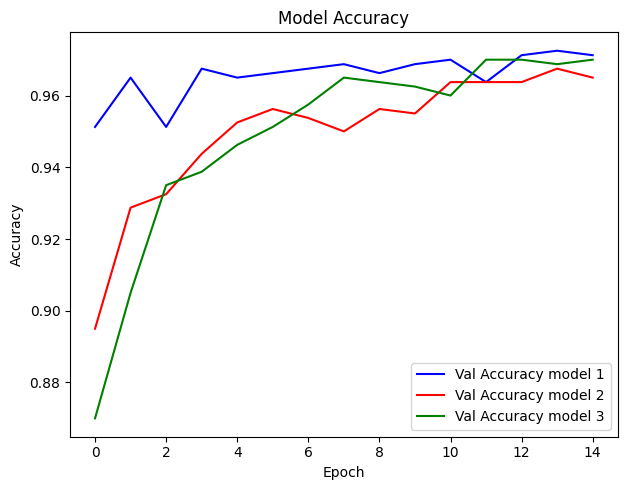

In [61]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['val_accuracy'], label='Val Accuracy model 1',color='blue')
plt.plot(history2.history['val_accuracy'], label='Val Accuracy model 2',color='red')
plt.plot(history3.history['val_accuracy'], label='Val Accuracy model 3', color='green')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()


plt.tight_layout()
plt.show()

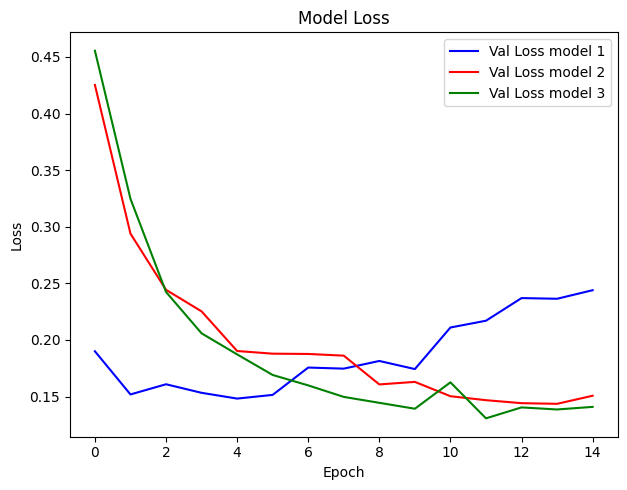

In [62]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Val Loss model 1',color='blue')
plt.plot(history2.history['val_loss'], label='Val Loss model 2',color='red')
plt.plot(history3.history['val_loss'], label='Val Loss model 3',color='green')

plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

0-> Bags
1-> Bottomwear
2-> Shoes
3-> Topwear
4-> Watches


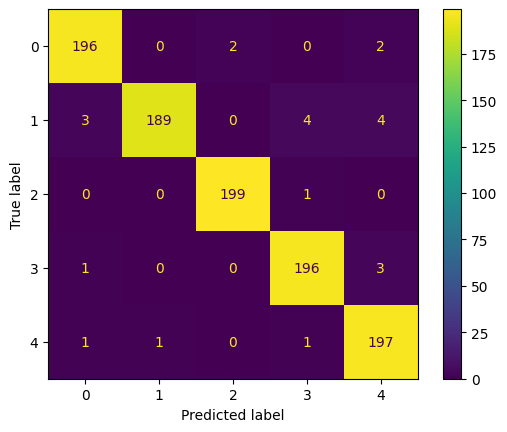

In [254]:
cm3 = confusion_matrix(y_test_flat,y_pred3,labels=list(decoder_dict.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm3,display_labels=list(decoder_dict.keys()))
disp.plot()
for i in list(decoder_dict.keys()):
  print(str(i)+"-> "+decoder_dict[i])

Validation model 3
0-> Bags
1-> Bottomwear
2-> Shoes
3-> Topwear
4-> Watches


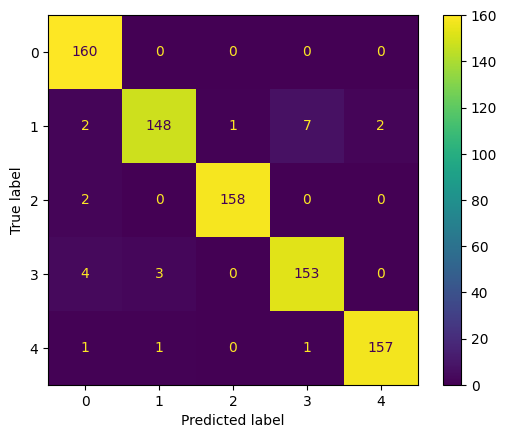

In [250]:
cm_val3 = confusion_matrix(y_val_flat,y_pred_val3,labels=list(decoder_dict.keys()))
disp = ConfusionMatrixDisplay(confusion_matrix=cm_val3,display_labels=list(decoder_dict.keys()))
disp.plot()
print("Validation model 3")
for i in list(decoder_dict.keys()):
  print(str(i)+"-> "+decoder_dict[i])

#Test with real image

In [331]:
from google.colab import files
uploaded = files.upload()

Saving Bags.webp to Bags.webp


In [332]:
filenames = uploaded.keys()
for file in filenames:
    data = uploaded[file]
name = file

In [333]:
path = "/content/"+name
test_image = Image.open(path)
test_image = test_image.convert('L') # grayscale
test_image = test_image.resize(SCALING_SIZE) # resize
test_image = np.asarray(test_image)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


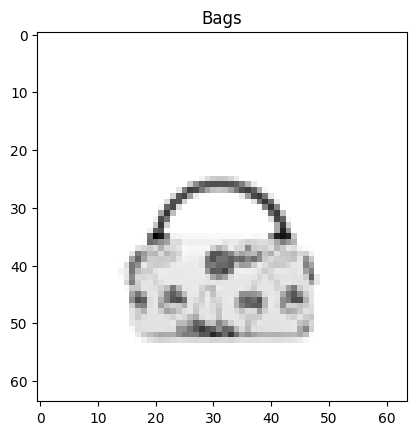

In [334]:
plt.imshow(test_image,cmap=plt.cm.gray)


test_image = np.array(test_image).reshape(-1, SCALING_SIZE[0], SCALING_SIZE[1], 1) / 255.0
y_pred_proba = model3.predict(test_image)
y_pred = np.argmax(y_pred_proba)

plt.title(decoder_dict[y_pred])
plt.show()

Saving 238760628.webp to 238760628.webp
Saving AJANTA24012421649copy.webp to AJANTA24012421649copy.webp
Saving B_CuteBoy_SummerDrop_Belife_B_d9b887e6-09df-4e43-b19b-38c296e77cb2_1200x.webp to B_CuteBoy_SummerDrop_Belife_B_d9b887e6-09df-4e43-b19b-38c296e77cb2_1200x.webp
Saving b2846773-06d2-49d3-8649-bacba5cb0da9.webp to b2846773-06d2-49d3-8649-bacba5cb0da9.webp
Saving Bags.webp to Bags (1).webp
Saving Bottomwears.webp to Bottomwears.webp
Saving custom-nike-dunk-high-by-you-shoes.avif to custom-nike-dunk-high-by-you-shoes (1).avif
Saving df6aebb1-a9ec-b8d2-7367-653f55ca449d.webp to df6aebb1-a9ec-b8d2-7367-653f55ca449d.webp
Saving doubleShoes.jpg to doubleShoes.jpg
Saving HC-0555_461448ee-a068-4c9f-baa7-7228a2bfd834.webp to HC-0555_461448ee-a068-4c9f-baa7-7228a2bfd834.webp
Saving Htcenly-Running-Shoes-Men-Fashion-Sneakers-Casual-Walking-Shoes-Sport-Athletic-Shoes-Lightweight-Breathable-Comfortable_4114141f-7d26-4dd7-933d-babc24080395.516ad145e1a1d8d82a801ac48231950d.avif to Htcenly-Runni

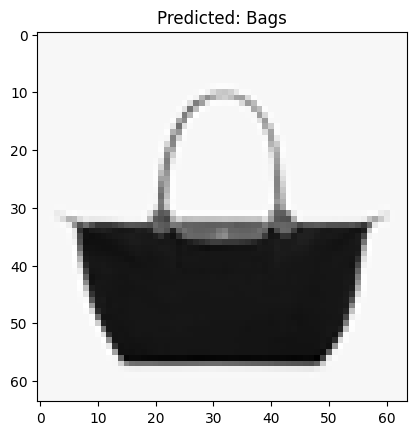

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


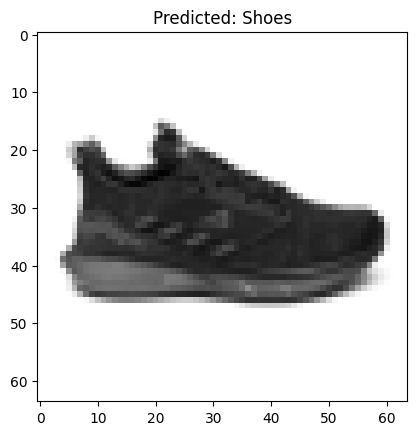

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


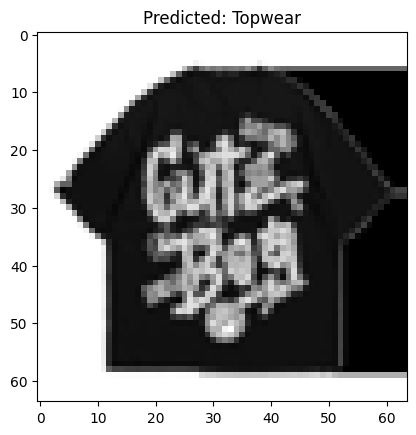

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


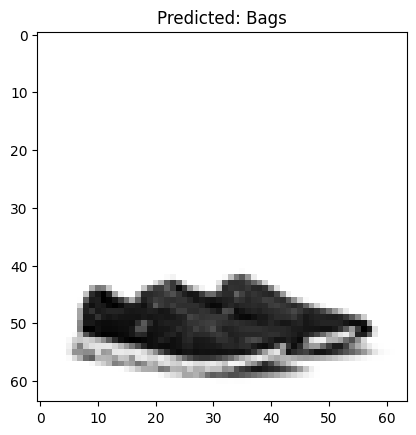

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


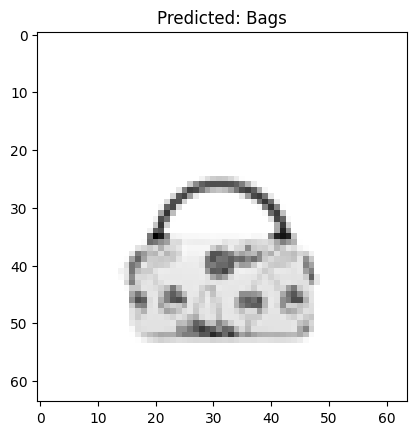

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


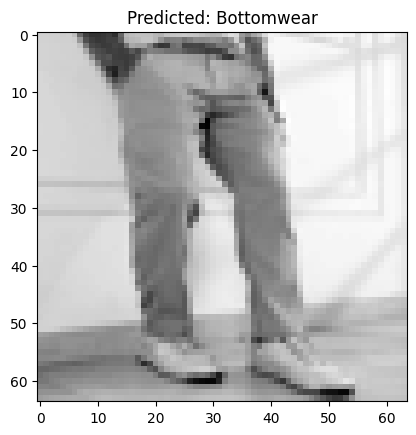

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


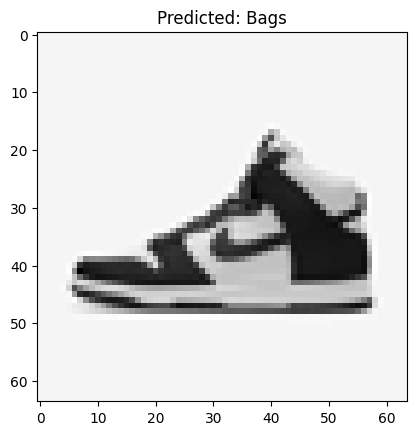

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


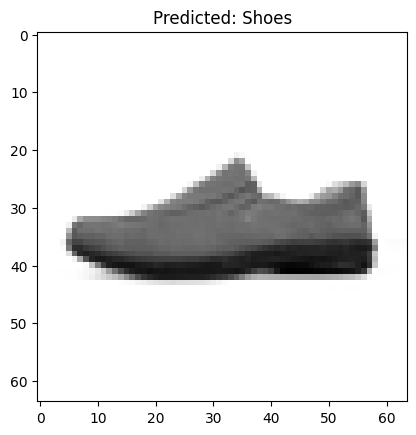

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


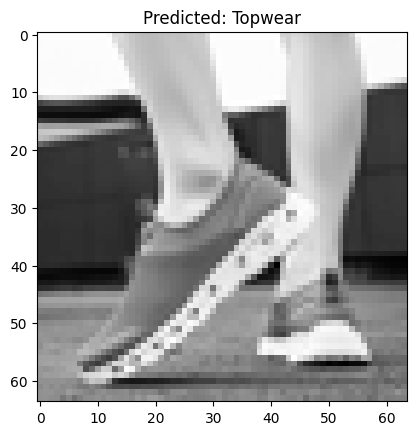

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


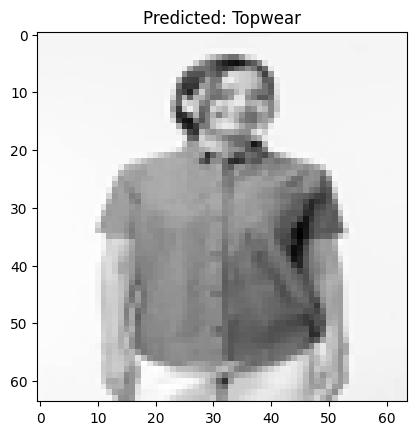

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


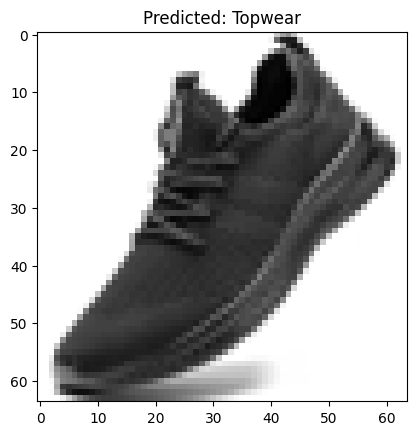

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


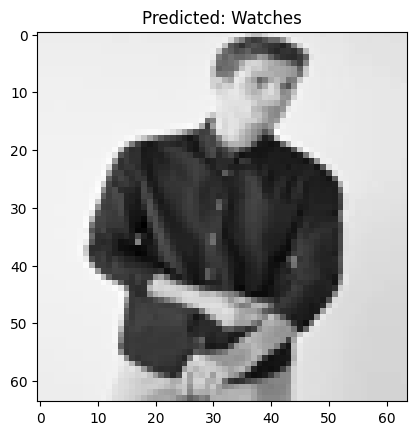

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


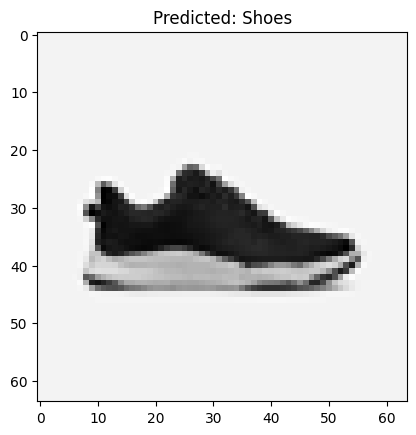

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


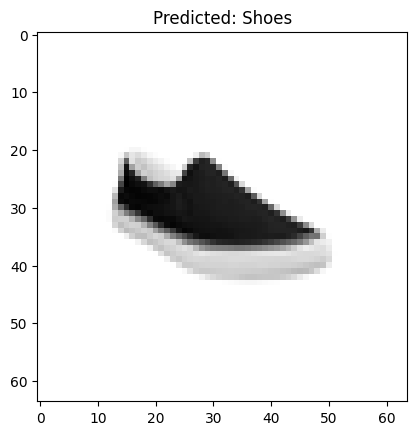

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


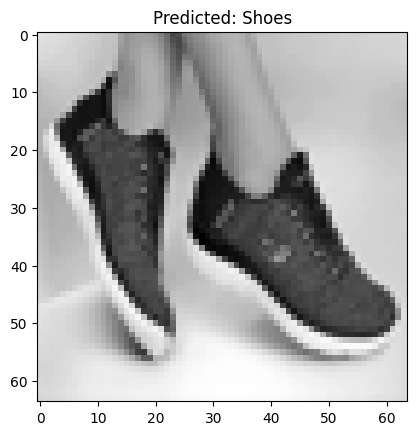

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


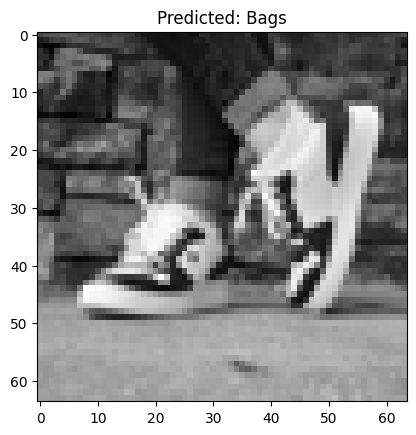

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


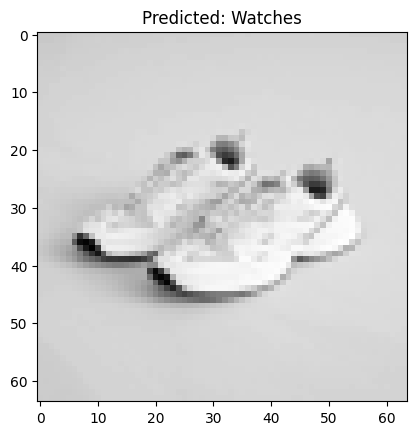

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


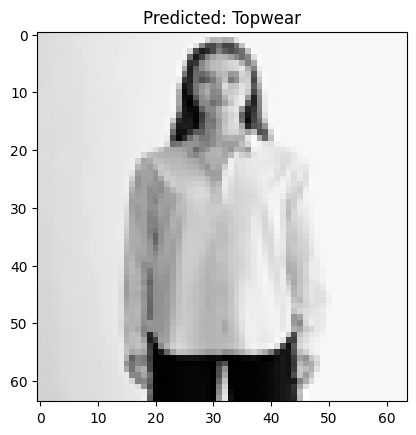

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


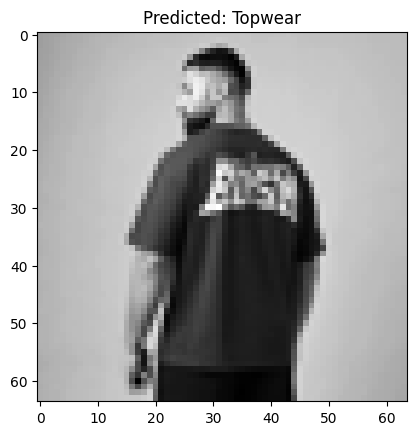

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


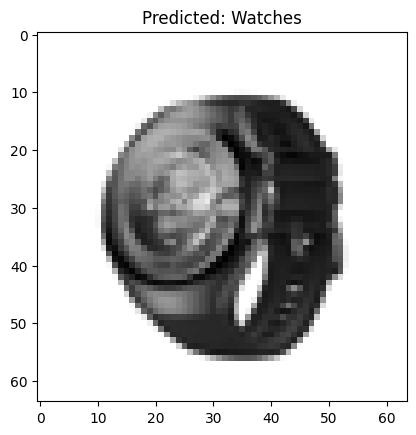

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


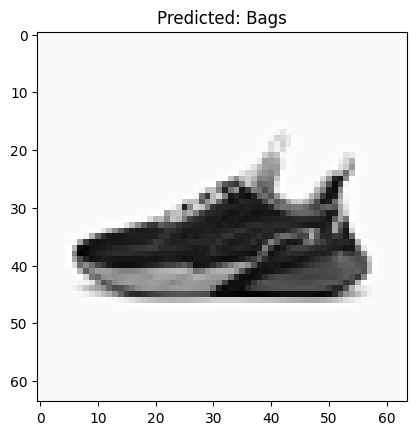

In [335]:
#Model 3
from google.colab import files
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

uploaded = files.upload()


for name, data in uploaded.items():

    path = "/content/" + name


    try:
        test_image = Image.open(path)
        test_image_L = test_image.convert('L')
        test_image_resized = test_image_L.resize(SCALING_SIZE)


        test_image_np = np.asarray(test_image_resized)
        plt.figure()
        plt.imshow(test_image_np, cmap=plt.cm.gray)

        test_image_input = np.array(test_image_np, copy=True).reshape(1, SCALING_SIZE[0], SCALING_SIZE[1], 1) / 255.0

        y_pred_proba = model3.predict(test_image_input)
        y_pred = np.argmax(y_pred_proba)

        predicted_label = decoder_dict.get(y_pred)
        plt.title(f"Predicted: {predicted_label}")
        plt.show()

    except Exception as e:
        print(f"Could not process file {name}. Error: {e}")
  #wrong 8 pic

Saving 238760628.webp to 238760628.webp
Saving AJANTA24012421649copy.webp to AJANTA24012421649copy.webp
Saving B_CuteBoy_SummerDrop_Belife_B_d9b887e6-09df-4e43-b19b-38c296e77cb2_1200x.webp to B_CuteBoy_SummerDrop_Belife_B_d9b887e6-09df-4e43-b19b-38c296e77cb2_1200x.webp
Saving b2846773-06d2-49d3-8649-bacba5cb0da9.webp to b2846773-06d2-49d3-8649-bacba5cb0da9.webp
Saving Bags.webp to Bags.webp
Saving Bottomwears.webp to Bottomwears.webp
Saving custom-nike-dunk-high-by-you-shoes.avif to custom-nike-dunk-high-by-you-shoes.avif
Saving df6aebb1-a9ec-b8d2-7367-653f55ca449d.webp to df6aebb1-a9ec-b8d2-7367-653f55ca449d.webp
Saving doubleShoes.jpg to doubleShoes.jpg
Saving HC-0555_461448ee-a068-4c9f-baa7-7228a2bfd834.webp to HC-0555_461448ee-a068-4c9f-baa7-7228a2bfd834.webp
Saving Htcenly-Running-Shoes-Men-Fashion-Sneakers-Casual-Walking-Shoes-Sport-Athletic-Shoes-Lightweight-Breathable-Comfortable_4114141f-7d26-4dd7-933d-babc24080395.516ad145e1a1d8d82a801ac48231950d.avif to Htcenly-Running-Shoes

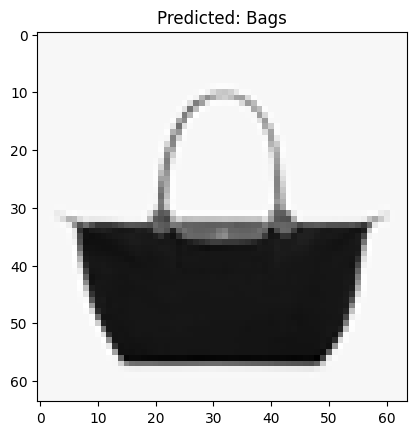

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


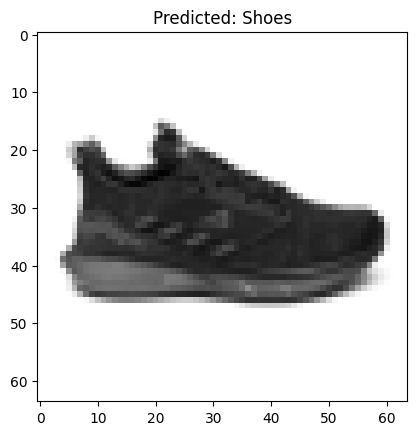

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


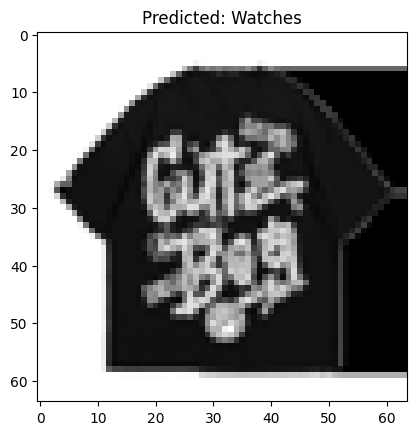

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


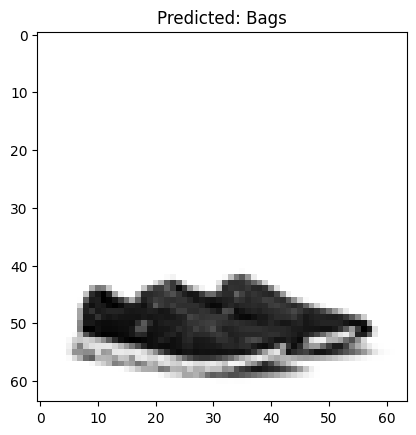

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


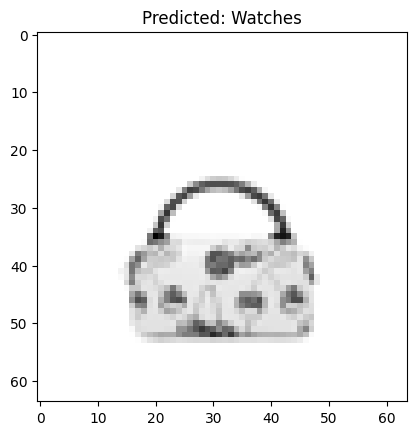

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


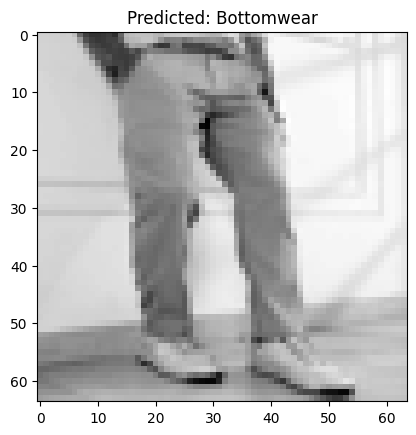

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


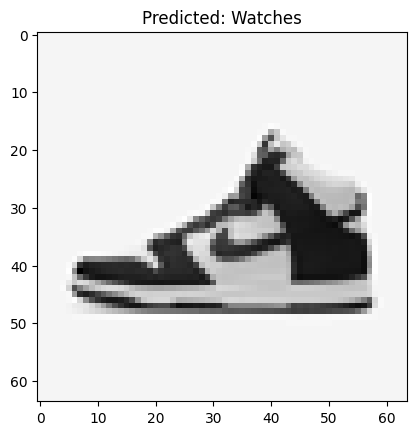

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


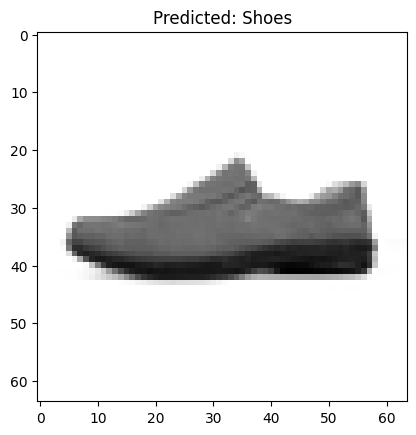

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


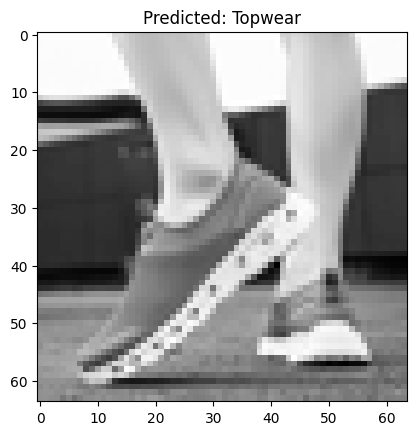

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


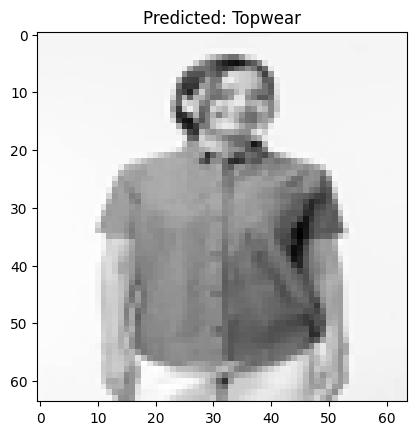

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


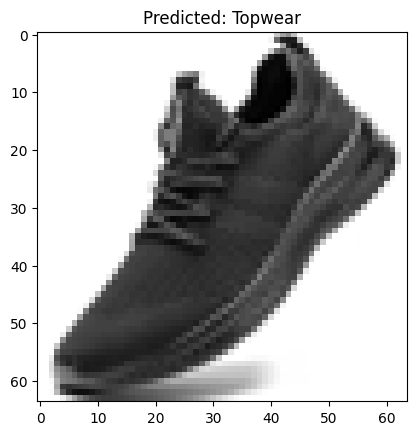

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


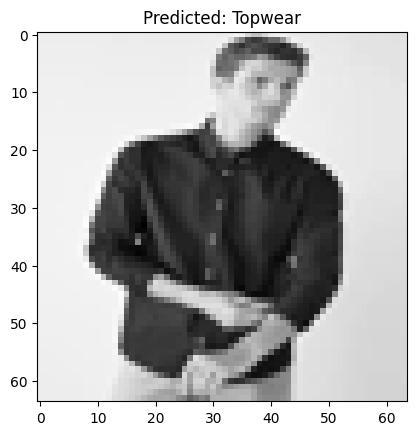

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


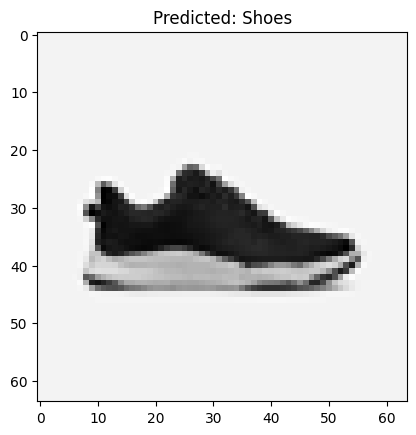

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


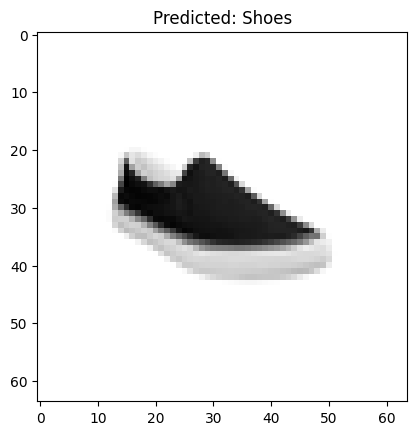

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


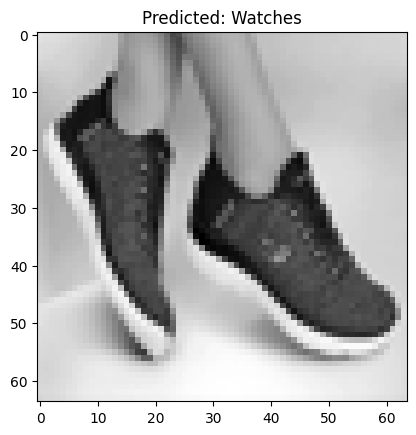

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


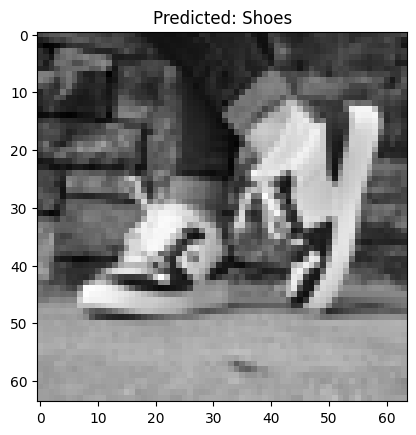

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


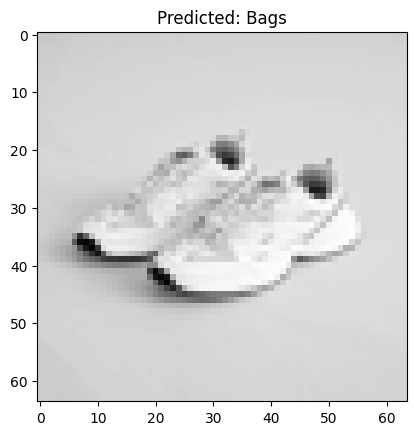

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


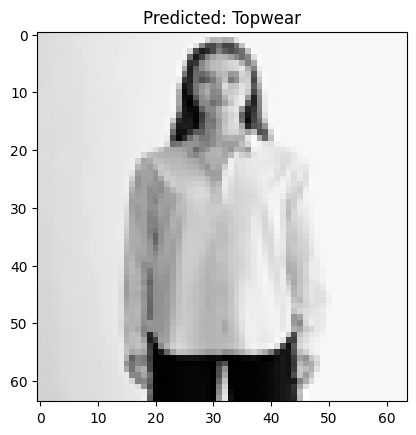

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


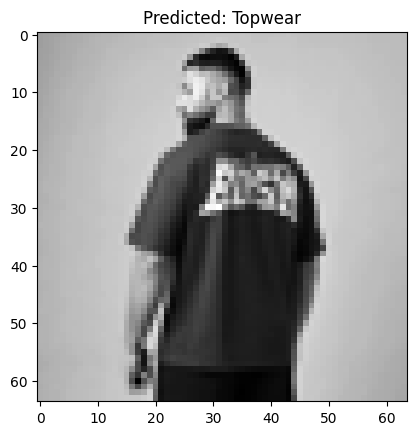

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step


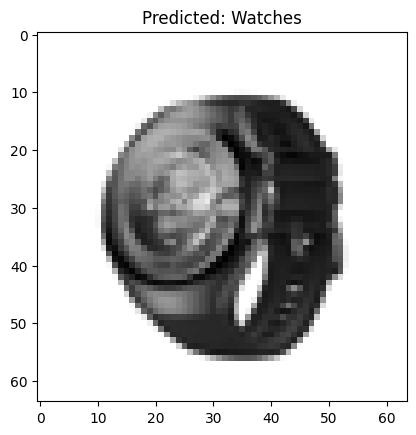

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


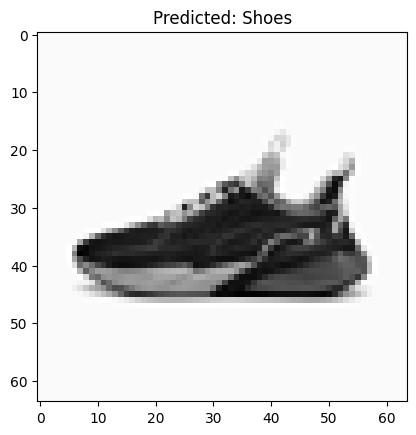

In [323]:
#Model 1
uploaded = files.upload()
for name, data in uploaded.items():

    path = "/content/" + name


    try:
        test_image = Image.open(path)
        test_image_L = test_image.convert('L')
        test_image_resized = test_image_L.resize(SCALING_SIZE)


        test_image_np = np.asarray(test_image_resized)
        plt.figure()
        plt.imshow(test_image_np, cmap=plt.cm.gray)

        test_image_input = np.array(test_image_np, copy=True).reshape(1, SCALING_SIZE[0], SCALING_SIZE[1], 1) / 255.0

        y_pred_proba = model.predict(test_image_input)
        y_pred = np.argmax(y_pred_proba)

        predicted_label = decoder_dict.get(y_pred)
        plt.title(f"Predicted: {predicted_label}")
        plt.show()

    except Exception as e:
        print(f"Could not process file {name}. Error: {e}")
#wrong pic 8

Saving 238760628.webp to 238760628 (1).webp
Saving AJANTA24012421649copy.webp to AJANTA24012421649copy.webp
Saving B_CuteBoy_SummerDrop_Belife_B_d9b887e6-09df-4e43-b19b-38c296e77cb2_1200x.webp to B_CuteBoy_SummerDrop_Belife_B_d9b887e6-09df-4e43-b19b-38c296e77cb2_1200x.webp
Saving b2846773-06d2-49d3-8649-bacba5cb0da9.webp to b2846773-06d2-49d3-8649-bacba5cb0da9.webp
Saving Bags.webp to Bags.webp
Saving Bottomwears.webp to Bottomwears.webp
Saving custom-nike-dunk-high-by-you-shoes.avif to custom-nike-dunk-high-by-you-shoes.avif
Saving df6aebb1-a9ec-b8d2-7367-653f55ca449d.webp to df6aebb1-a9ec-b8d2-7367-653f55ca449d.webp
Saving doubleShoes.jpg to doubleShoes.jpg
Saving HC-0555_461448ee-a068-4c9f-baa7-7228a2bfd834.webp to HC-0555_461448ee-a068-4c9f-baa7-7228a2bfd834.webp
Saving Htcenly-Running-Shoes-Men-Fashion-Sneakers-Casual-Walking-Shoes-Sport-Athletic-Shoes-Lightweight-Breathable-Comfortable_4114141f-7d26-4dd7-933d-babc24080395.516ad145e1a1d8d82a801ac48231950d.avif to Htcenly-Running-S

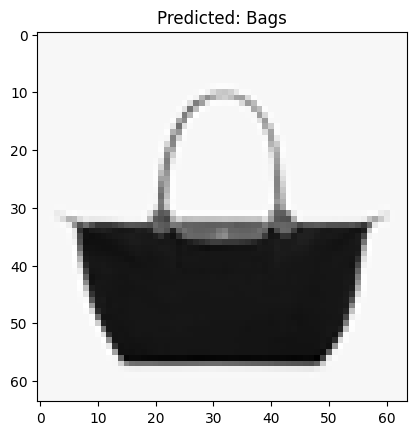

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step


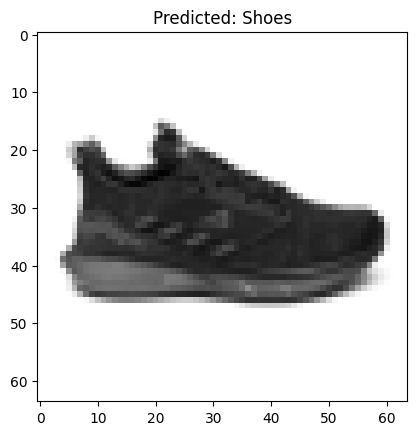

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


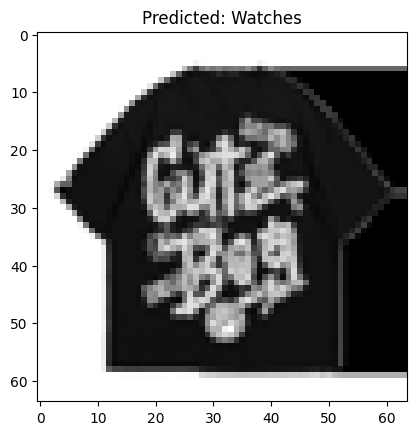

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


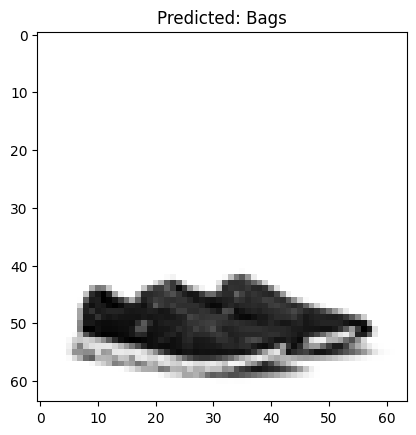

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


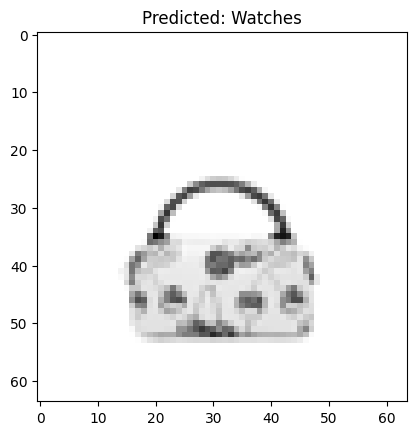

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


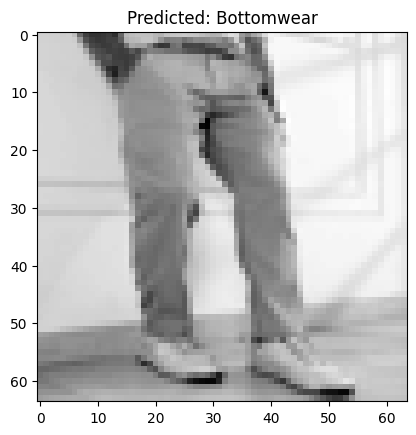

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


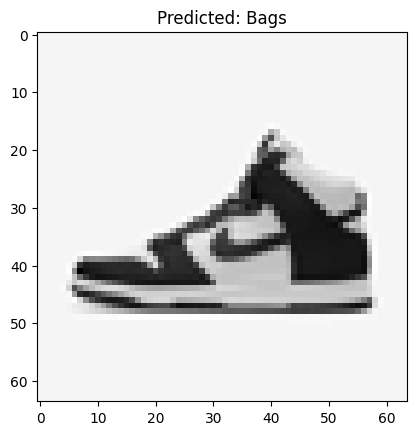

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


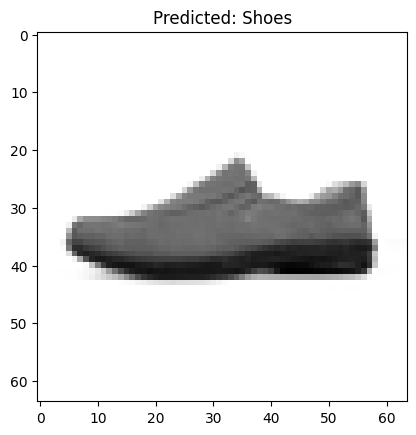

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


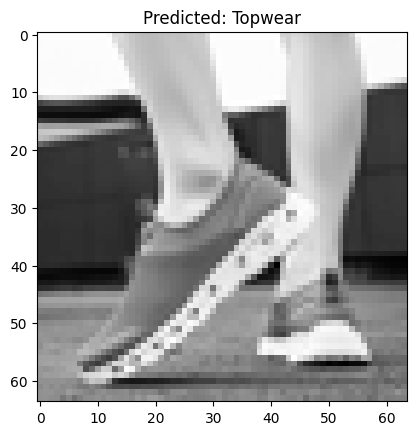

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


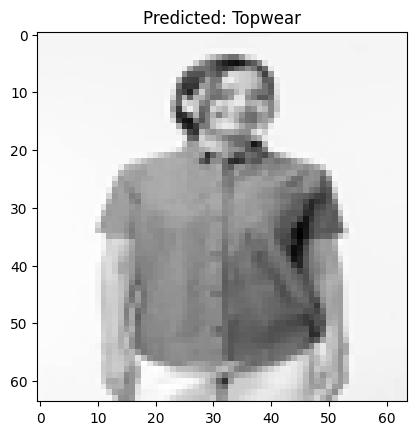

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


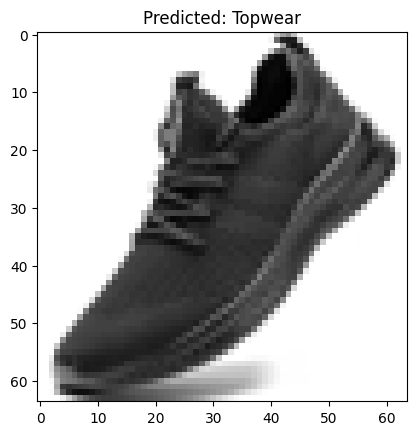

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


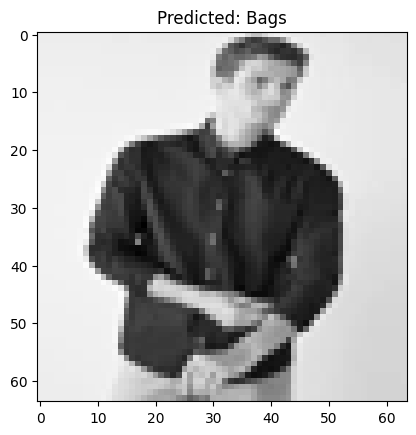

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


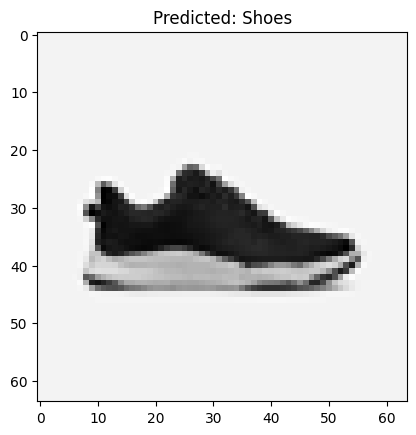

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


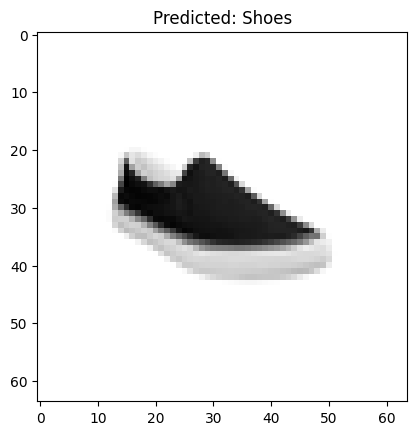

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


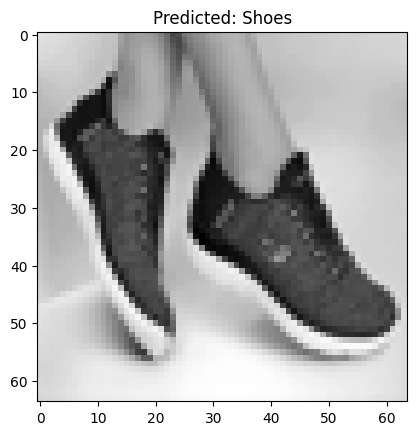

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step


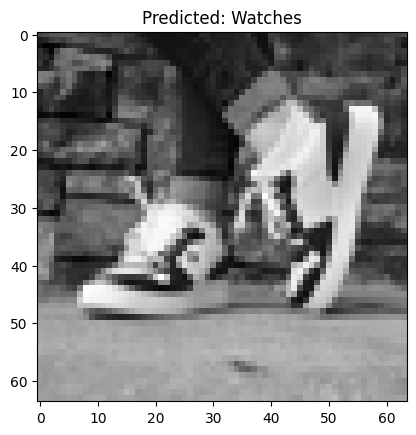

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


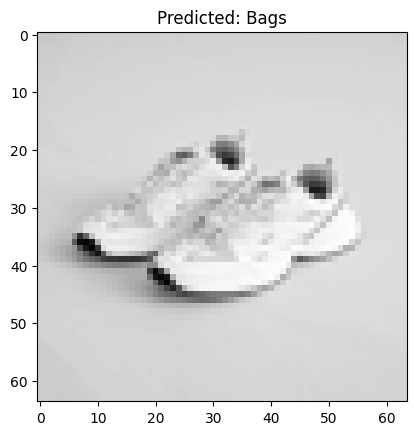

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


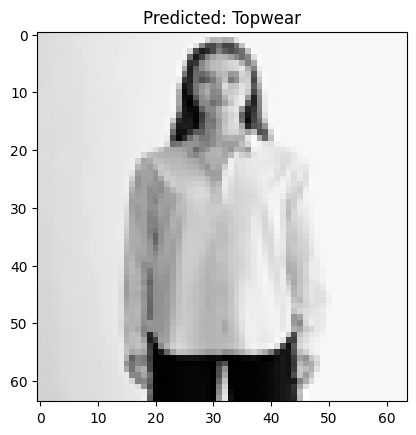

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


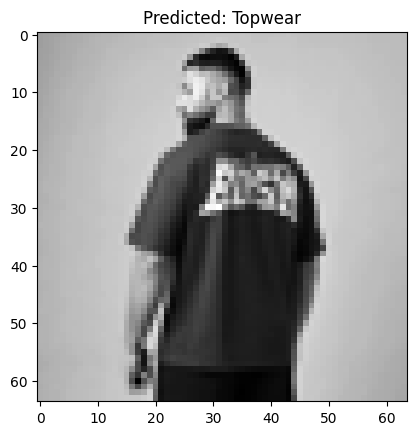

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


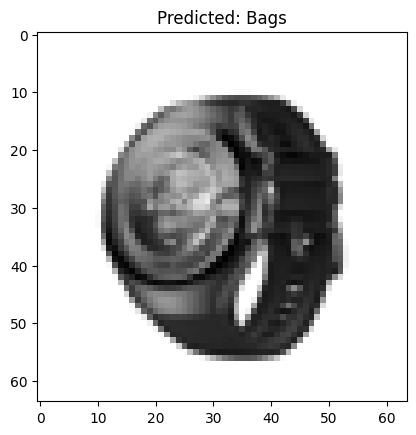

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


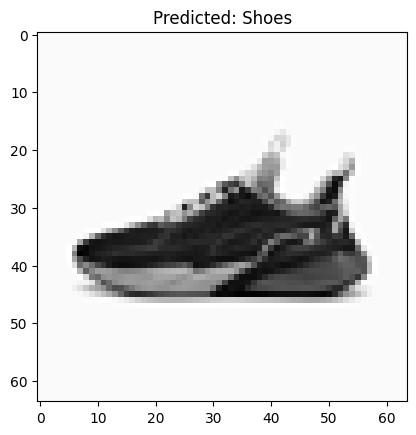

In [324]:
#Model 2
uploaded = files.upload()
for name, data in uploaded.items():

    path = "/content/" + name


    try:
        test_image = Image.open(path)
        test_image_L = test_image.convert('L')
        test_image_resized = test_image_L.resize(SCALING_SIZE)


        test_image_np = np.asarray(test_image_resized)
        plt.figure()
        plt.imshow(test_image_np, cmap=plt.cm.gray)

        test_image_input = np.array(test_image_np, copy=True).reshape(1, SCALING_SIZE[0], SCALING_SIZE[1], 1) / 255.0

        y_pred_proba = model2.predict(test_image_input)
        y_pred = np.argmax(y_pred_proba)

        predicted_label = decoder_dict.get(y_pred)
        plt.title(f"Predicted: {predicted_label}")
        plt.show()

    except Exception as e:
        print(f"Could not process file {name}. Error: {e}")
#wrong pic 10